In [1]:
import json
import http.client
from urllib.parse import urlencode, quote_plus, quote
import pandas as pd
from datetime import datetime
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
import matplotlib.pyplot as plt
from datetime import datetime
import networkx as nx
import numpy as np
from tsclustering.data import get_dataset_list, get_series_by_dataset_name, get_serie_observations, get_dataset_observations

/home/clem/Documents/source/sandbox/webstat-tsclustering/.venv/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Récupération de la liste des datasets

Enregistrement `catalogue.csv`

In [2]:
dataset_dict = get_dataset_list()

print(dataset_dict)
dataset_names = [dataset["name"] for dataset in dataset_dict]

annuaire_df = pd.DataFrame(dataset_dict)
annuaire_df.to_csv("catalogue.csv", index=False)
annuaire_df.to_markdown(buf="catalogue.md", index=False)

[{'name': 'DIREN', 'description': 'Observatoire des Entreprises', 'lastUpdate': '2023-08-30 19:14:36.0'}, {'name': 'SC1', 'description': 'Emission et détention  de titres - France', 'lastUpdate': '2023-08-30 19:14:36.0'}, {'name': 'STS', 'description': 'Coûts salariaux, Emploi, Chômage', 'lastUpdate': '2023-08-30 19:14:36.0'}, {'name': 'MIR1', 'description': "Taux d'intérêt - France", 'lastUpdate': '2023-08-30 19:38:47.0'}, {'name': 'CPP', 'description': 'Prix immobilier commercial', 'lastUpdate': '2023-08-30 19:04:54.0'}, {'name': 'CFT', 'description': 'Comptes financiers trimestriels', 'lastUpdate': '2023-08-30 19:57:05.0'}, {'name': 'FM', 'description': 'Marché financier, taux', 'lastUpdate': '2023-08-31 09:48:09.0'}, {'name': 'CONJ2', 'description': 'Enquêtes de Conjoncture Régionales', 'lastUpdate': '2023-08-30 20:23:37.0'}, {'name': 'SA', 'description': 'Comptes Nationaux SA', 'lastUpdate': '2023-08-30 20:03:05.0'}, {'name': 'CONJ', 'description': 'Enquêtes de Conjoncture Nationa

In [5]:
annuaire_df = pd.read_csv("catalogue.csv")
dataset_names = annuaire_df["name"].tolist()

# Get dataset observations

In [7]:
get_dataset_observations(dataset_names[0])

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

# Récupération de la liste des séries d'un dataset

In [5]:
sts_series = get_series_by_dataset_name("STS")


KeyError: 0

In [6]:
sts_series

{'httpCode': '429',
 'httpMessage': 'Too Many Requests',
 'moreInformation': 'Rate Limit exceeded'}

In [ ]:
series_cache = {}

In [31]:
for dataset_name in dataset_names:
    if dataset_name in series_cache:
        series = series_cache[dataset_name]
    else:
        series = get_series_by_dataset_name(dataset_name)
        series_cache[dataset_name] = series

    for serie in series:
        serie_key = serie["seriesKey"]
        serie_dataset = serie["dataset"]
        serie_title = serie["title"]

## Save series meta to `series_metas.csv`

In [ ]:
series_cache.to_csv("series_metas.csv")

In [34]:
all_series = sum(list(series_cache.values()), [])

## Frequency distribution

In [65]:
# 'DimensionValue': {'code': 'FREQ', 'value': 'M'}

all_serie_frequencies = [dimension_value["DimensionValue"]["value"] for serie in all_series for dimension_value in serie["dimensionsValues"] if dimension_value["DimensionValue"]["code"] == "FREQ"]

frequencies = pd.DataFrame(all_serie_frequencies, columns=["freq"])
frequencies["count"] = 1
frequencies.groupby("freq").sum()

,count
freq,
A,1231
M,1408
Q,734
W,1


## Timespan Distribution

In [66]:
# 'from': '01/12/1992', 'to': '01/04/2023'

datetime_format = "%d/%m/%Y"

all_serie_timespans = [(datetime.strptime(serie["from"], datetime_format),
                        datetime.strptime(serie["to"], datetime_format)) for serie in all_series]



In [72]:
all_serie_years = [(all_serie_timespan[0].year, all_serie_timespan[1].year) for all_serie_timespan in all_serie_timespans]

timespan_df = pd.DataFrame(all_serie_years, columns=["from", "to"])
timespan_df["count"] = 1
grouped_timespan_df = timespan_df.groupby(["from", "to"]).sum()

grouped_timespan_df.to_markdown("serie_timespans.md")


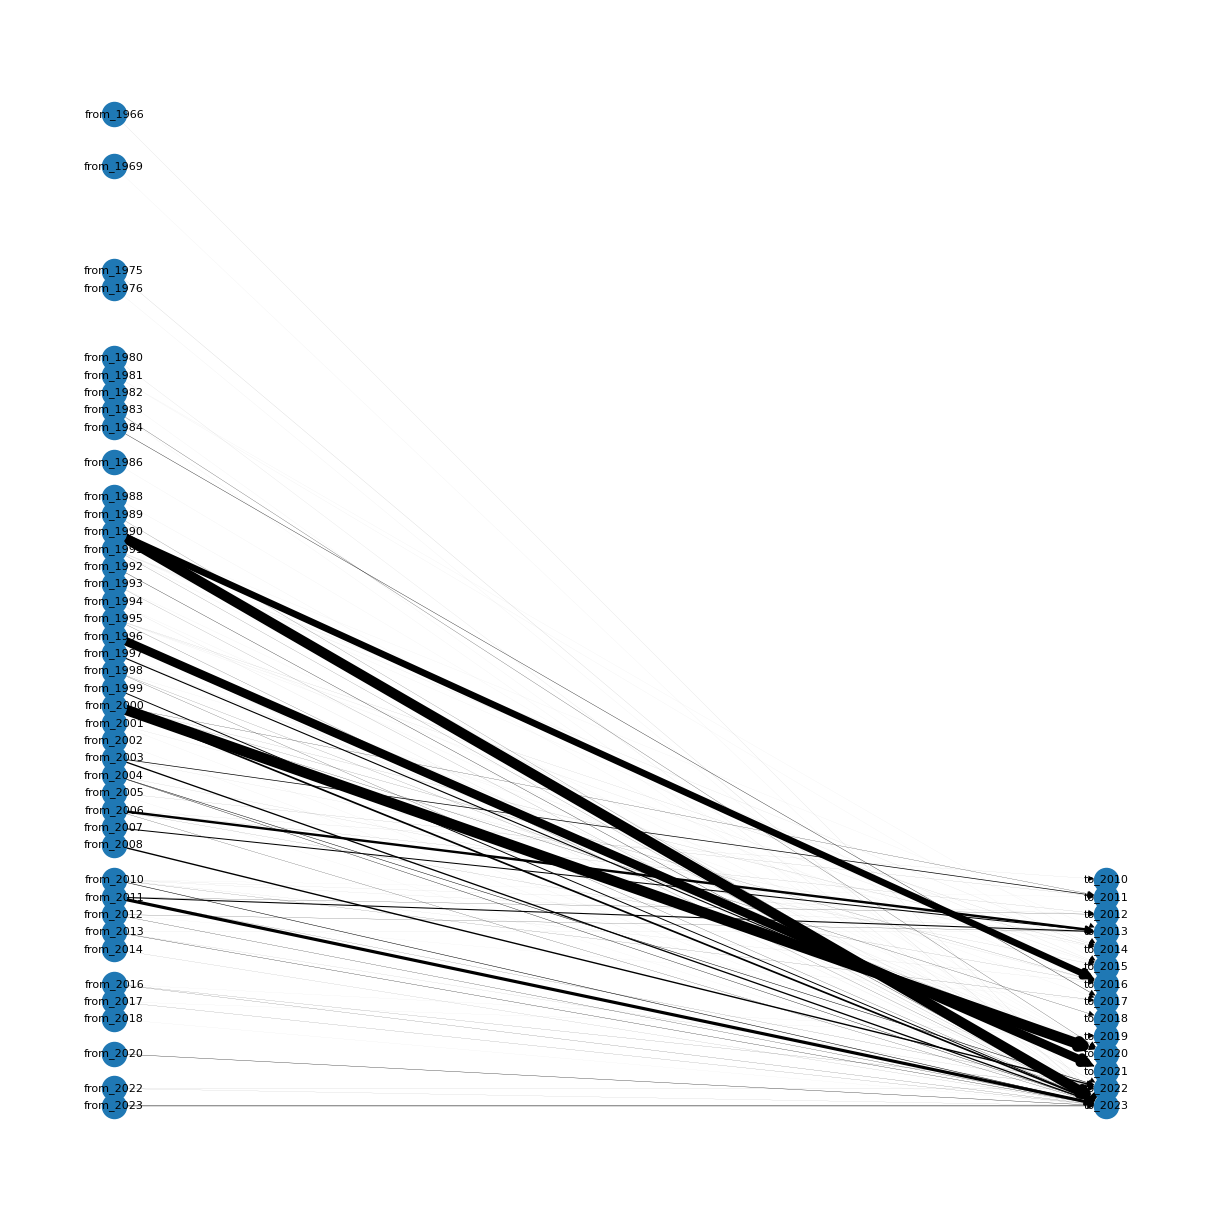

In [120]:
graph = nx.DiGraph()
from_nodes = []
to_nodes = []
for i, row in grouped_timespan_df.iterrows():
        weight = row["count"]
        from_edge = f"from_{row.name[0]}"
        to_edge = f"to_{row.name[1]}"

        from_nodes.append(from_edge)
        to_nodes.append(to_edge)

        graph.add_edge(from_edge, to_edge, weight=weight)

pos = nx.random_layout(graph)
# pos = nx.circular_layout(graph.subgraph(from_nodes + to_nodes))

for i, from_node in enumerate(set(from_nodes)):
        y_pos = -int(from_node.replace("from_", ""))
        pos[from_node] = np.array([-10, y_pos])

for i, to_node in enumerate(set(to_nodes)):
        y_pos = -int(to_node.replace("to_", ""))
        pos[to_node] = np.array([10, y_pos])


edges = graph.edges()
weights = [graph[u][v]['weight'] for u,v in edges]

plt.figure(figsize=(12,12))
nx.draw(graph, pos, with_labels=True, node_size=200, font_size=8, width=np.array(weights) / 80)

## Filter series by **frequency** and **timespan** attributes

In [121]:
# filter by frequency
filtered_series = list(
    filter(
        lambda x:filter(
            lambda y: y["DimensionValue"]["code"] == "FREQ" and y["DimensionValue"]["value"] == "M",
            x["dimensionsValues"]
        ),
        all_series
    )
)

# filter by date
filtered_series = list(
    filter(
        lambda x: datetime.strptime(x["from"], datetime_format).year < 2001 and datetime.strptime(x["to"], datetime_format).year > 2019,
        filtered_series
    )
)

# Récupération des observations d'un dataset
Cet API requête l'ensemble des données d'un dataset. Certains datasets contiennent plusieurs centaines de milliers d'observations. En cas d'erreur (timeout) ou de temps de chargement excessif, il sera nécessaire de restreindre le nombre d'observations demandé à l'aide des différents paramètres ou d'utiliser l'API de requête par séries.

In [155]:
observations_cache = {}

In [156]:
all_observations = []
for filtered_serie in filtered_series:
    if filtered_serie["seriesKey"] not in observations_cache:
        observations = get_serie_observations(dataset=filtered_serie["dataset"], serie_key=filtered_serie["seriesKey"])
        observations_cache[filtered_serie["seriesKey"]] = observations
    else:
        observations = observations_cache[filtered_serie["seriesKey"]]
    
    if observations:
        all_observations.append(observations)

In [157]:
obs_dict_list = {}
for serie_observations in all_observations:
    obs_dict = {
        datetime.strptime(observation_period["ObservationPeriod"]["periodFirstDate"], "%d-%m-%Y 00:00:00"): observation_period["ObservationPeriod"]["value"]
        for observation_period in serie_observations["ObservationsSerie"]["observations"]
    }
    obs_ds_name = serie_observations["ObservationsSerie"]["title"]
    obs_dict_list[obs_ds_name] = obs_dict


In [158]:
final_df = pd.DataFrame(obs_dict_list)
final_df.to_csv("final_df.csv")

# TODO: Move following cells

In [ ]:
french_months = {
    "Jan": 1,
    "Fév": 2,
    "Mar": 3,
    "Avr": 4,
    "Mai": 5,
    "Jun": 6,
    "Jul": 7,
    "Aoû": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Déc": 12,
}

In [ ]:
my_df = pd.DataFrame(ds_dict)
datetime_df = []
for index in my_df.index:
    month, year = index.split(" ")
    datetime_df.append(datetime(int(year), french_months[month], 1))

my_df.index = datetime_df
my_df = my_df.sort_index()
# my_df = my_df.asfreq('m')

In [ ]:
my_df_nn = my_df.dropna(axis=1,thresh=300)
my_df_nn = my_df_nn.dropna(axis=0)